## Import the necessary libraries

In [600]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [601]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Let's understand the given data and Prepare the train, validation and test data from the given csv files.

In [602]:
# read the dataset
df = pd.read_csv('train.csv')

In [603]:
df.head(10)

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
7,2017-02-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
8,2017-03-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,350000,1
9,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1


In [604]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [605]:
# convert the dates to datetime
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])
# calculate the service period in months
df['Service period'] = (df['MMM-YY'] - df['Dateofjoining']) // np.timedelta64(1, 'M')
df['Service period'] = np.where(df['Service period'] < 0, 0, df['Service period'])
# check how many levels the employee has been promoted
df['Promoted by'] = df['Designation']- df['Joining Designation'] 
# check if salary has been increased
df['Salary increased'] = df.groupby('Emp_ID')['Salary'].diff().gt(0)
# check if rating has been increased
df['Rating increased'] = df.groupby('Emp_ID')['Quarterly Rating'].diff().agg(lambda x: 1 if x > 0 else 0)
# check if rating has been decreased
df['Rating decreased'] = df.groupby('Emp_ID')['Quarterly Rating'].diff().agg(lambda x: 1 if x < 0 else 0)
# create the feature last business value
df['Last Business Value'] = df['Total Business Value'].shift()

In [606]:
# extract the Quarter from Date
df['Quarter'] = df.iloc[:,0].dt.to_period('Q')

In [607]:
# extract the target feature
attrition_status = df.groupby(['Emp_ID', 'Quarter'])['LastWorkingDate'].last().agg(lambda x: int(pd.notna(x)))
last_quart = max(df['Quarter'].unique())

In [608]:
def get_group(g, key1, key2):
    try:
        return g[key1][key2]
    except:
        return 0
get_group(attrition_status, 1, '2016Q1')

1

In [609]:
for i in range(df.shape[0]):
    curr_quart = df.loc[i, 'Quarter']
    emp_id = df.loc[i, 'Emp_ID']
    if attrition_status[emp_id][curr_quart] == 1:
        df.loc[i, 'Attrition'] = 1
    elif ((curr_quart + 1) <= last_quart) and get_group(attrition_status, emp_id, curr_quart+1):
        df.loc[i, 'Attrition'] = 1
    elif ((curr_quart + 2) <= last_quart) and get_group(attrition_status, emp_id, curr_quart+2):
        df.loc[i, 'Attrition'] = 1
    else:
        df.loc[i, 'Attrition'] = 0

In [610]:
df['Attrition'] = df['Attrition'].astype('int')
df['Attrition'].value_counts()

0    10711
1     8393
Name: Attrition, dtype: int64

In [611]:
df['Salary increased'] = df['Salary increased'].astype('category').cat.codes
df['Education_Level'] = df['Education_Level'].astype('category').cat.codes
df['Gender'] = df['Gender'].astype('category').cat.codes

In [612]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,Service period,Promoted by,Salary increased,Rating increased,Rating decreased,Last Business Value,Quarter,Attrition
0,2016-01-01,1,28,1,C23,2,57387,2015-12-24,NaT,1,1,2381060,2,0,0,0,0,0,NaN,2016Q1,1
1,2016-02-01,1,28,1,C23,2,57387,2015-12-24,NaT,1,1,-665480,2,1,0,0,0,0,2381060.0,2016Q1,1
2,2016-03-01,1,28,1,C23,2,57387,2015-12-24,2016-03-11,1,1,0,2,2,0,0,0,0,-665480.0,2016Q1,1
3,2017-11-01,2,31,1,C7,2,67016,2017-11-06,NaT,2,2,0,1,0,0,0,0,0,0.0,2017Q4,0
4,2017-12-01,2,31,1,C7,2,67016,2017-11-06,NaT,2,2,0,1,0,0,0,0,0,0.0,2017Q4,0


In [613]:
data = df.drop(columns = ['Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'City', 'Quarter'])

### Let's do some basic EDA on the data

In [614]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Emp_ID                19104 non-null  int64         
 2   Age                   19104 non-null  int64         
 3   Gender                19104 non-null  int8          
 4   Education_Level       19104 non-null  int8          
 5   Salary                19104 non-null  int64         
 6   Designation           19104 non-null  int64         
 7   Total Business Value  19104 non-null  int64         
 8   Quarterly Rating      19104 non-null  int64         
 9   Service period        19104 non-null  int64         
 10  Promoted by           19104 non-null  int64         
 11  Salary increased      19104 non-null  int8          
 12  Rating increased      19104 non-null  int64         
 13  Rating decreased

In [615]:
data['Last Business Value'] = data['Last Business Value'].fillna(0)

<AxesSubplot:xlabel='Month', ylabel='% Attrition'>

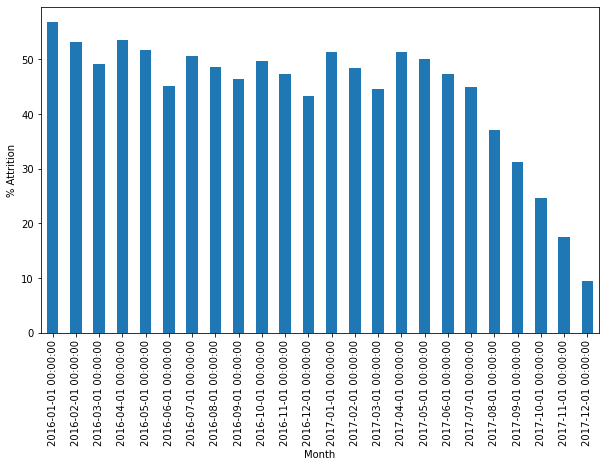

In [616]:
# check attrition by month
Attrition_by_month = data.groupby(['MMM-YY'])['Attrition'].agg(lambda x: x.sum() * 100 / x.count())
Attrition_by_month.plot(kind = 'bar', ylabel='% Attrition',
         xlabel='Month', figsize=(10, 6))

<AxesSubplot:xlabel='Gender', ylabel='Attrition'>

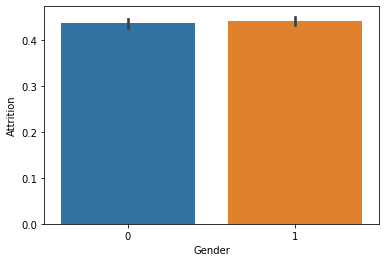

In [617]:
sns.barplot(x = 'Gender', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Education_Level', ylabel='Attrition'>

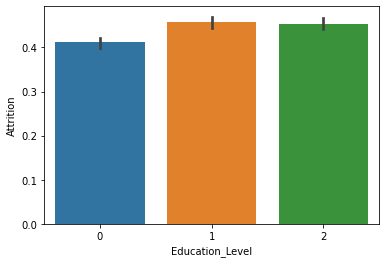

In [618]:
sns.barplot(x = 'Education_Level', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Designation', ylabel='Attrition'>

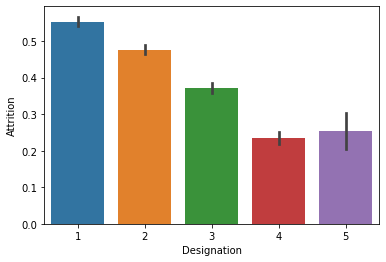

In [619]:
sns.barplot(x = 'Designation', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Promoted by', ylabel='Attrition'>

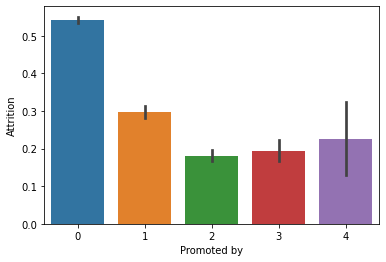

In [620]:
sns.barplot(x = 'Promoted by', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Quarterly Rating', ylabel='Attrition'>

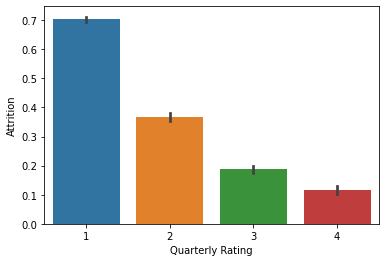

In [621]:
sns.barplot(x = 'Quarterly Rating', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Salary increased', ylabel='Attrition'>

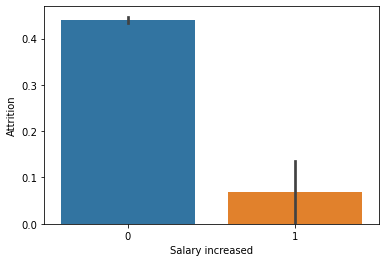

In [622]:
sns.barplot(x = 'Salary increased', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Rating increased', ylabel='Attrition'>

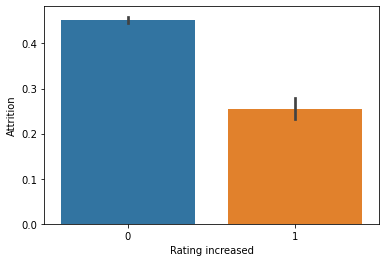

In [623]:
sns.barplot(x = 'Rating increased', y = 'Attrition', data = data)

<AxesSubplot:xlabel='Rating decreased', ylabel='Attrition'>

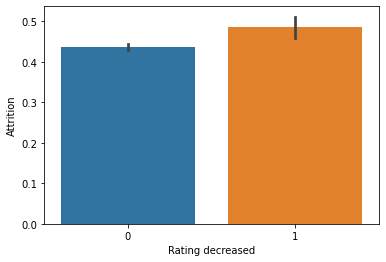

In [624]:
sns.barplot(x = 'Rating decreased', y = 'Attrition', data = data)

In [625]:
data = data.sort_values(['MMM-YY', 'Attrition'], ascending=[True, False])

In [626]:
data.head()

,MMM-YY,Emp_ID,Age,Gender,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating,Service period,Promoted by,Salary increased,Rating increased,Rating decreased,Last Business Value,Attrition
0,2016-01-01,1,28,1,2,57387,1,2381060,2,0,0,0,0,0,0.0,1
10,2016-01-01,5,29,1,1,46368,1,0,1,0,0,0,0,0,0.0,1
54,2016-01-01,16,30,0,1,52963,2,346800,1,1,0,0,0,0,0.0,1
56,2016-01-01,17,42,1,2,51099,1,100000,2,9,0,0,0,0,0.0,1
63,2016-01-01,18,27,0,0,31631,1,0,1,0,0,0,0,0,0.0,1


### Separate out the test data

In [627]:
test_ids = pd.read_csv('test.csv')

In [628]:
data_dec17 = data[data['MMM-YY'] == '2017-12-01']
test_data = pd.DataFrame({'Emp_ID': test_ids.iloc[:, 0]}).merge(data_dec17)
test_data = test_data.drop(columns = ['Attrition'])

In [629]:
train_data = data[data['MMM-YY'] != '2017-12-01'] 

In [630]:
test_data.head()

,Emp_ID,MMM-YY,Age,Gender,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating,Service period,Promoted by,Salary increased,Rating increased,Rating decreased,Last Business Value
0,394,2017-12-01,34,0,2,97722,4,2701750,3,77,2,0,0,0,1433660.0
1,173,2017-12-01,39,1,1,56174,3,706010,3,77,2,0,0,0,1102120.0
2,1090,2017-12-01,39,1,1,96750,4,1518520,2,77,2,0,0,0,562170.0
3,840,2017-12-01,40,0,1,88813,4,1151820,2,76,3,0,0,0,278340.0
4,308,2017-12-01,32,1,2,188418,5,3772910,2,75,3,0,0,0,1037000.0


In [631]:
train_data.head()

,MMM-YY,Emp_ID,Age,Gender,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating,Service period,Promoted by,Salary increased,Rating increased,Rating decreased,Last Business Value,Attrition
0,2016-01-01,1,28,1,2,57387,1,2381060,2,0,0,0,0,0,0.0,1
10,2016-01-01,5,29,1,1,46368,1,0,1,0,0,0,0,0,0.0,1
54,2016-01-01,16,30,0,1,52963,2,346800,1,1,0,0,0,0,0.0,1
56,2016-01-01,17,42,1,2,51099,1,100000,2,9,0,0,0,0,0.0,1
63,2016-01-01,18,27,0,0,31631,1,0,1,0,0,0,0,0,0.0,1


In [632]:
train_data['Attrition'].value_counts()

0    9970
1    8315
Name: Attrition, dtype: int64

### Split the rest of the data into train and validation set

In [633]:
train_data_1 = train_data[train_data['MMM-YY'] != '2016-12-01']

valid_data = train_data[train_data['MMM-YY'] == '2016-12-01']

x_train = train_data_1.drop(columns = ['Emp_ID', 'MMM-YY', 'Attrition', 'Gender', 'Salary increased', 
                                                    'Rating increased', 'Rating decreased'])
y_train = train_data_1['Attrition']

x_valid = valid_data.drop(columns = ['Emp_ID', 'MMM-YY', 'Attrition', 'Gender', 'Salary increased', 
                                                    'Rating increased', 'Rating decreased'])
y_valid = valid_data['Attrition']

In [634]:
y_valid.value_counts()

0    451
1    344
Name: Attrition, dtype: int64

### Model building

In [635]:
clf = AdaBoostClassifier(random_state = 1)

In [636]:
clf.fit(x_train, y_train)

AdaBoostClassifier(random_state=1)

<AxesSubplot:>

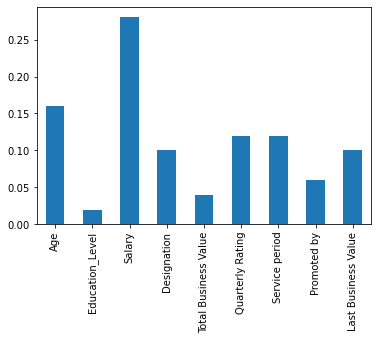

In [637]:
importances = pd.Series(clf.feature_importances_, index = x_train.columns)
fig, ax = plt.subplots()
importances.plot.bar(importances, ax=ax)

In [638]:
y_pred = clf.predict(x_valid)

In [639]:
confusion_matrix(y_pred, y_valid)

array([[301,  81],
       [150, 263]], dtype=int64)

In [640]:
f1_score(y_pred, y_valid)

0.6948480845442536

### Final model and prediction on test data

In [641]:
X = train_data.drop(columns = ['Emp_ID', 'MMM-YY', 'Attrition', 'Gender', 'Rating increased', 
                               'Salary increased', 'Rating decreased'])
Y = train_data['Attrition']

In [642]:
clf.fit(X, Y)

AdaBoostClassifier(random_state=1)

<AxesSubplot:>

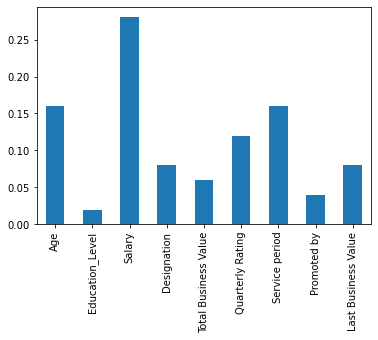

In [643]:
importances = pd.Series(clf.feature_importances_, index = X.columns)
fig, ax = plt.subplots()
importances.plot.bar(importances, ax=ax)

In [644]:
y_pred_test = clf.predict(test_data.drop(columns = ['Emp_ID', 'MMM-YY', 'Gender', 'Salary increased', 
                                                    'Rating increased', 'Rating decreased']))
sum(y_pred_test)

321

In [645]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,Emp_ID,Target
0,394,0
1,173,0
2,1090,0
3,840,0
4,308,0


In [646]:
submission['Target'] = y_pred_test
submission.head()

,Emp_ID,Target
0,394,0
1,173,0
2,1090,0
3,840,0
4,308,0


In [647]:
submission.to_csv('submission.csv', index = False)